# The Memonomicon

This notebook provides a friendly introduction to memo. It is well-suited for people who already have some familiarity with the art of Bayesian modeling in cognitive science (e.g. with WebPPL). Some practice with array programming in Python (e.g. libraries like NumPy, PyTorch, or JAX) may also be helpful.

In [1]:
# !pip install memo-lang

import jax
import jax.numpy as np
from memo import memo

## Hello, memo!

At its heart, memo is a language for modeling the _choices_ made by _agents_. For example, suppose Alice chooses a card among three options, uniformly at random. Let us start by computing the expected value of the number on the card.

If we were expressing this situation in mathematical notation, we might say that Alice choses $c \sim \text{Uniform}(\text{cards})$, or perhaps $p(c) \propto 1$, and that we wish to compute $\textbf{E}[c]$.

To express this in memo, first we create a representation of the set of cards:

In [2]:
cards = np.array([1, 2, 3])

Then, we create a memo that represents Alice choosing one of the cards with uniform probability.

In [3]:
@memo
def alice_chooses_card():
    cast: [alice]
    alice: chooses(c in cards, wpp=1)
    return E[alice.c]

+ `@memo` is a tag that tells memo to interpret the function as memo code rather than Python code.
+ `cast` tells memo the names of the agents being modeled (like a cast of characters in a play). In this case, there is only one (Alice).
+ `chooses` says that Alice picks one card among `cards`, and calls that card `c`.
+ `wpp` stands for **"with probability proportional to"**. Here, Alice chooses with probability proportional to 1, i.e. uniformly at random. In general, we can write arbitrary expressions after `wpp` to express probability distributions, which memo will automatically normalize.
+ The `return` line says we should compute the expected value of Alice's card (`alice.c`).

We can run this memo by calling it just like a Python function.

In [4]:
alice_chooses_card()

Array(2., dtype=float32)

The return value is a JAX array, which indeed contains 2, the average card value.

## Array programming in memo

Another way to think about memo is as a language for defining tables of values. For example, suppose we wanted to create a table that shows the probability that Alice chooses each card. We could do this by introducing a new **axis** to our memo `alice_chooses_card[c: card]`), and `return`-ing the probability that Alice's chosen card is `c` (given by `E[alice.c == c]`).

You can think of introducing an axis as saying: "for every possible value of `c` in `cards`, run this model and give me the outputs in a table."

In [34]:
@memo
def alice_chooses_card[c: cards]():  # notice the new axis c
    cast: [alice]
    alice: chooses(c in cards, wpp=1)
    return E[alice.c == c]

alice_chooses_card()

Array([0.33333334, 0.33333334, 0.33333334], dtype=float32)

The result is what we expect: a uniform distribution, 1/3 probability each.

Let's try a more interesting distribution. Suppose Alice is likelier to pick a card with a higher value: for example, suppose $p(c) \propto \exp(\beta \cdot c)$, i.e. Alice chooses based on a softmax over card values with some temperature $\beta$. We can model this in memo by introducing a **parameter** `beta`, and editing the `wpp` of Alice's choice accordingly.

Notice that **axes** appear in square brackets and **parameters** appear in round parentheses in the definition of a memo. These are different! You should think of axes as representing the combinatorial space of possible conditions/scenarios/outcomes of an experiment, and parameters as free parameters of the model.

Our new model, run with $\beta = 3$, shows that Alice is overwhelmingly likelier to choose card 3 than either card 1 or card 2. She is also about $20\times$ likelier to choose card 2 over card 1.

In [35]:
@memo
def alice_chooses_card[c: cards](beta):  # notice the new parameter beta
    cast: [alice]
    alice: chooses(c in cards, wpp=exp(beta * c))  # notice new wpp
    return E[alice.c == c]

alice_chooses_card(3.0)

Array([0.00235563, 0.04731416, 0.9503302 ], dtype=float32)

Now, let's introduce a new agent. Suppose Bob also wants to choose a card — he doesn't care about the value, but he wants to avoid choosing the same card as Alice.

First, take a moment to test your intuition: what do you expect? Knowing what he does about Alice, Bob will undoubtedly avoid card 3. We should therefore expect him to probably pick card 1 or card 2, with a slight preference for card 1.

To model this in memo, we create a new memo called `bob_chooses_card`, where the cast includes both Alice and Bob. Then, we use the **thinks** statement to express _Bob's mental model of Alice_. Notice that Alice's `wpp` references the `alice_chooses_card` memo we defined above, with $\beta=3$. Importantly, Bob doesn't _know_ what Alice's card is: internally, memo models Bob's uncertainty over Alice's choice.

Finally, we model Bob's choice as avoiding Alice's choice (`wpp=E[~(c == alice.c)]`). Notice that we need the expected value because Bob doesn't know `alice.c`. Finally, we compute a probability distribution over Bob's card choices as before (`E[bob.c == c]`).

In [38]:
@memo
def bob_chooses_card[c: cards]():
    cast: [alice, bob]
    bob: thinks[  # Bob's mental model of Alice
        alice: chooses(
            c in cards,
            wpp=alice_chooses_card[c is self.c](3.0)  # reference previous memo
        )
    ]

    # Bob avoids Alice's card
    bob: chooses(c in cards, wpp=E[~(c == alice.c)])
    return E[bob.c == c]
bob_chooses_card()

Array([0.49882218, 0.47634292, 0.02483489], dtype=float32)

Here is the result we expect: Bob is roughly ambivalent between cards 1 and 2, but avoids card 3.

Let us finish this section by visualizing the full matrix of possible game outcomes.

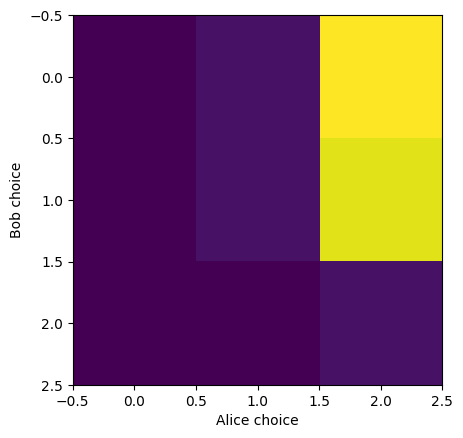

In [46]:
@memo
def all_outcomes[a: cards, b: cards]():
    cast: [alice, bob]
    alice: chooses(c in cards, wpp=alice_chooses_card[c is self.c](3.0))
    bob: chooses(c in cards, wpp=bob_chooses_card[c is self.c]())
    return E[alice.c == a and bob.c == b]

from matplotlib import pyplot as plt
plt.imshow(all_outcomes())
plt.xlabel('Alice choice')
plt.ylabel('Bob choice')
None

## Scalar implicature

## Fitting parameters

In [5]:
N = [0, 1, 2, 3]  # number of nice people
U = [0, 1, 2]     # utterance: {none, some, all} of the people are nice

@jax.jit
def meaning(n, u):
    return np.array([
        n == 0,  # none
        n > 0,   # some
        n == 3   # all
    ])[u]

@memo
def scalar():
    cast: [speaker, listener]
    forall: n in N
    forall: u in U

    listener: thinks[
        speaker: given(n in N, wpp=1),
        speaker: chooses(u in U, wpp=imagine[
            listener: knows(self.u),
            listener: chooses(n in N, wpp=meaning(n, u)),
            E[listener.n == self.n]
        ])
    ]
    listener: observes [speaker.u] is self.u
    listener: chooses(n in N, wpp=E[speaker.n == n])

    return E[listener.n == n]

print(scalar())

[[1.         0.         0.         0.        ]
 [0.         0.44444445 0.44444445 0.11111111]
 [0.         0.         0.         1.        ]]


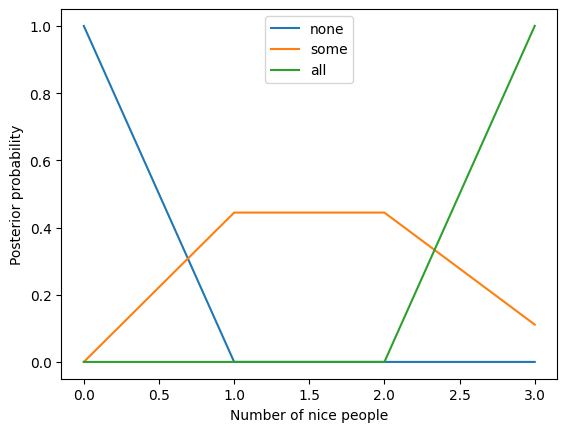

In [6]:
from matplotlib import pyplot as plt
plt.plot(scalar().T, label=['none', 'some', 'all'])
plt.xlabel('Number of nice people')
plt.ylabel('Posterior probability')
plt.legend()

In [7]:
@memo
def f():
    cast: []
    forall: a in cards
    forall: b in cards
    return a + b
f()

Array([[2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]], dtype=int32)